# Import Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['font.size']=12

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

import torch
torch.set_default_dtype(torch.double)
from botorch.models import SingleTaskGP
from botorch.models.model_list_gp_regression import ModelListGP
from botorch.optim.optimize import optimize_acqf
from botorch.acquisition.objective import GenericMCObjective
from botorch.acquisition.logei import qLogExpectedImprovement
from botorch.sampling.normal import SobolQMCNormalSampler
from gpytorch.mlls import ExactMarginalLogLikelihood, SumMarginalLogLikelihood
from botorch import fit_gpytorch_model

# Create DataFrame

In [2]:
data = pd.read_excel('HER HEO Data.xlsx')
data

,TimeOFF,TimeON,Potential,O2,Fe,Co,Ni,Cu,Zn,OverPotential
0,10,10,-1.5,61.110,0.160,1.800,8.050,28.500,0.390,-346.51
1,10,20,-1.5,44.340,3.510,7.410,9.810,30.780,4.140,-301.07
2,10,40,-1.5,49.290,2.040,5.910,10.890,23.970,7.890,-189.35
3,10,50,-1.5,47.160,3.260,4.930,9.960,28.360,6.330,-228.81
4,20,10,-1.5,71.900,0.980,0.320,2.700,23.480,0.630,-610.26
...,...,...,...,...,...,...,...,...,...,...
72,50,20,-1.7,65.458,17.328,2.248,3.534,9.594,1.838,-334.50
73,50,30,-1.7,55.106,11.064,3.012,8.844,19.652,2.326,-366.16
74,50,40,-1.7,57.588,8.224,3.482,8.494,20.076,2.138,-355.03
75,50,50,-1.7,53.172,9.358,6.862,12.570,16.134,1.906,-276.40


# Exploratory Data Analysis

In [3]:
# Define lists of input and output variable names with LaTeX-style subscripts
input_vars = ['Time OFF', 'Time ON', 'Potential']
outputs = ['O_2', 'Fe', 'Co', 'Ni', 'Cu', 'Zn', 'Overpotential']

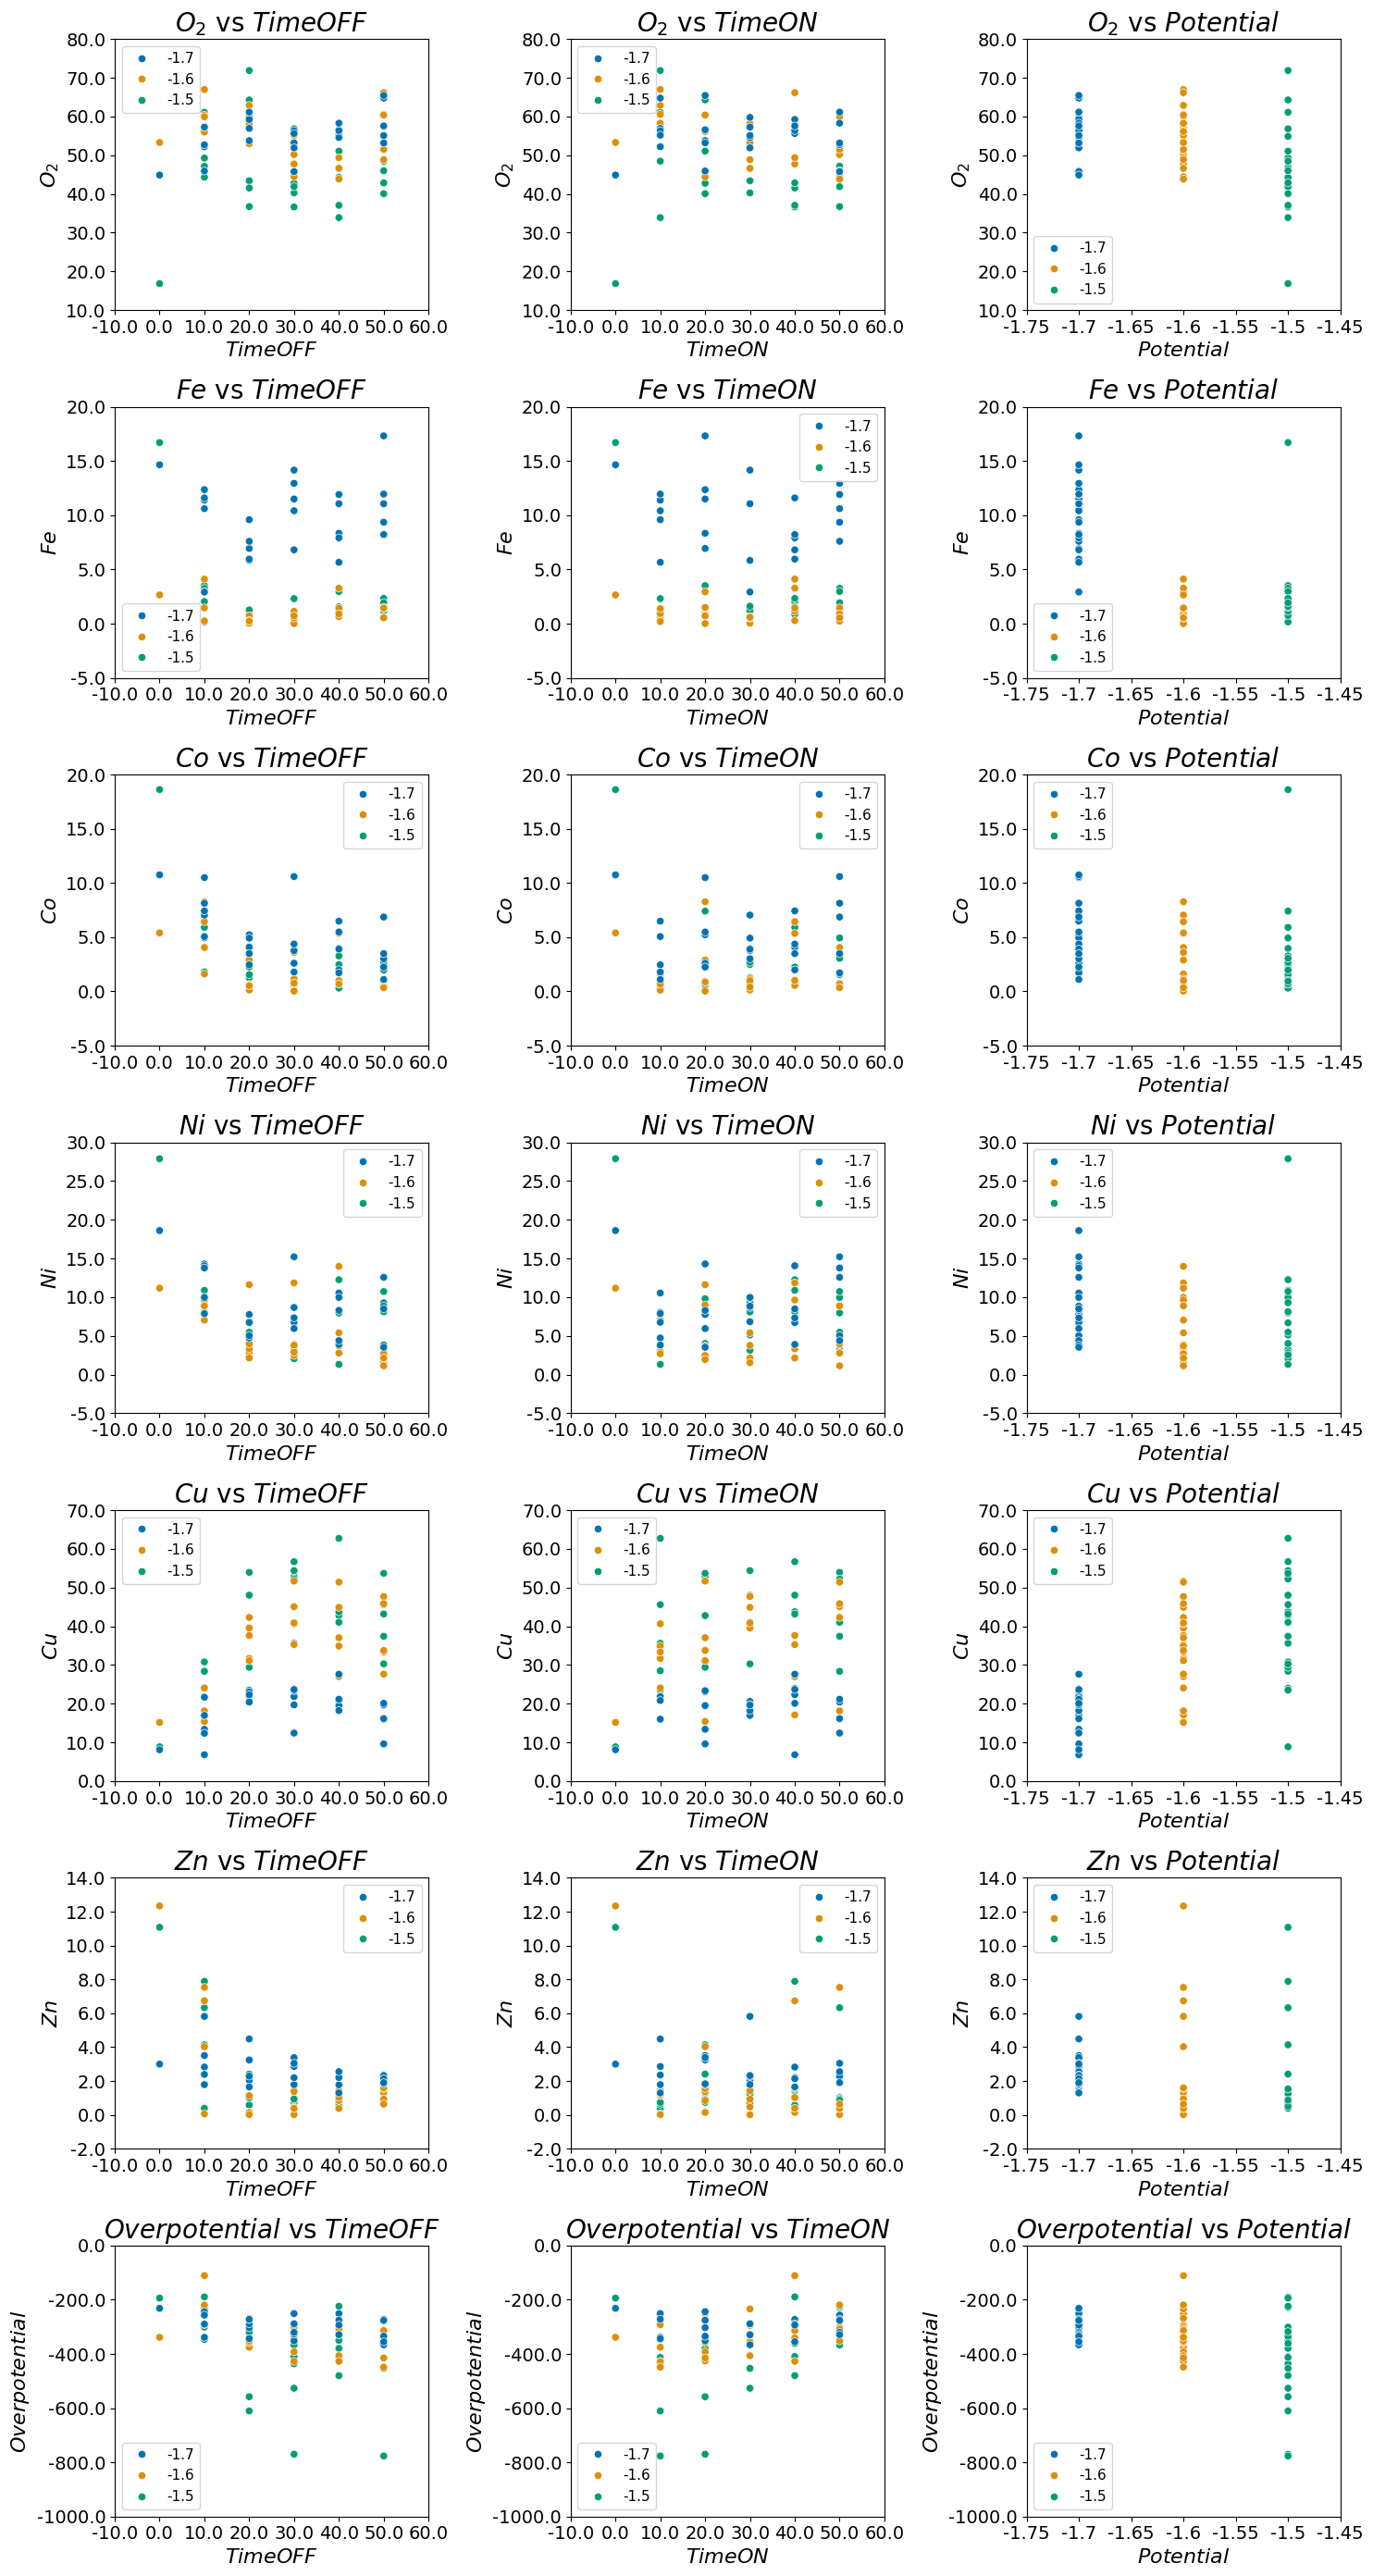

In [4]:
# Prepare the figure and axes for the scatter plots
fig, axes = plt.subplots(nrows=len(outputs), ncols=len(input_vars), figsize=(15, 28))  # Adjust the size as needed

# Flatten axes array if necessary
if len(outputs) == 1:
    axes = np.expand_dims(axes, axis=0)
elif len(input_vars) == 1:
    axes = np.expand_dims(axes, axis=1)

# 3 sets of colors for the different variables
colors = ['#824D74', '#535C91', '#ED8240', '#3F7D58', '#443627', '#4635B1', '#4C585B']

# Iterate over each input variable and output to create scatter plots
for i, out_var in enumerate(outputs):
    for j, in_var in enumerate(input_vars):
        ax = axes[i][j]  # Select the appropriate subplot
        sns.scatterplot(ax=ax, data=data, x=data.iloc[:,j], y=data.iloc[:,i+3], hue=data['Potential'], palette='colorblind', edgecolor='w')
        ax.set_title(r'$'+out_var+'$'+' vs '+r'$'+in_var+'$', fontsize=20)  # Set title for each subplot
        ax.set_xlabel(r'$'+in_var+'$', fontsize=16)  # Set x-axis label
        ax.set_ylabel(r'$'+out_var+'$', fontsize=16)  # Set y-axis label
        ax.set_xticks(ax.get_xticks())
        ax.set_yticks(ax.get_yticks())
        ax.set_xticklabels(ax.get_xticks(), fontsize=14)
        ax.set_yticklabels(ax.get_yticks(), fontsize=14)
        ax.legend(title_fontsize=11, fontsize=11)

# Adjust layout to prevent label overlap
plt.tight_layout()
plt.show()

fig.savefig('Plots/Distribution of Outputs vs Inputs.jpg')

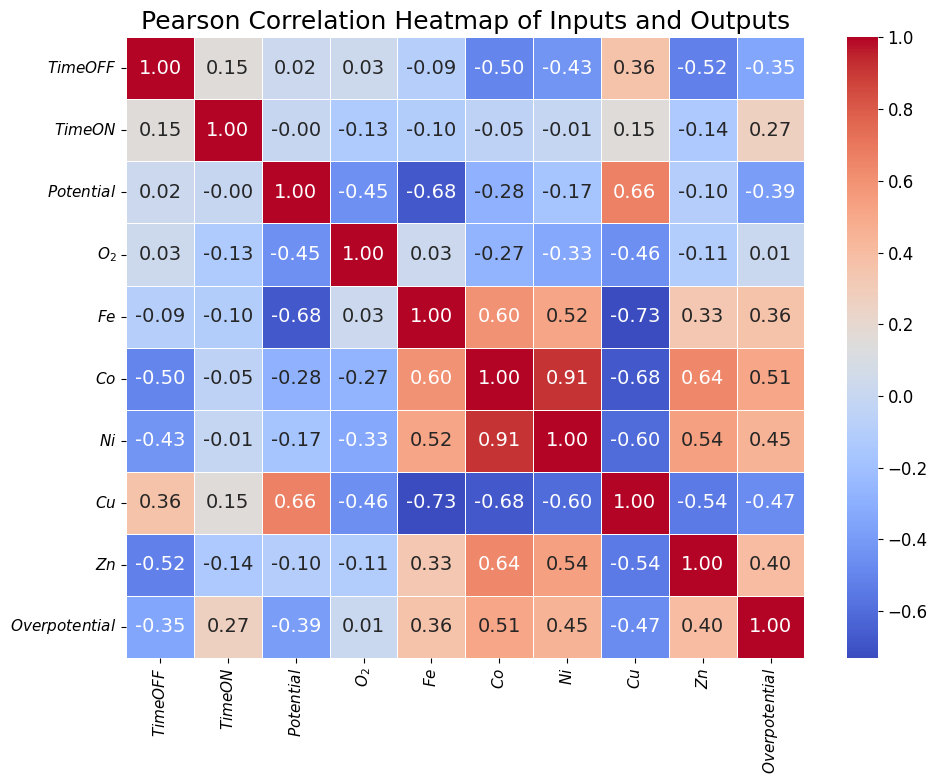

In [5]:
# Calculate the Pearson correlation matrix
correlation_matrix = data.corr()

# Create a heatmap to visualize the correlations
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(correlation_matrix, annot=True, annot_kws={'size':14}, cmap='coolwarm', fmt=".2f", linewidths=.5, 
            xticklabels=[r'$'+ label + '$' for label in input_vars + outputs],
            yticklabels=[r'$'+ label + '$' for label in input_vars + outputs])
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.title('Pearson Correlation Heatmap of Inputs and Outputs', fontsize=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

fig.savefig('Plots/Pearson Correlation Heatmap.jpg')

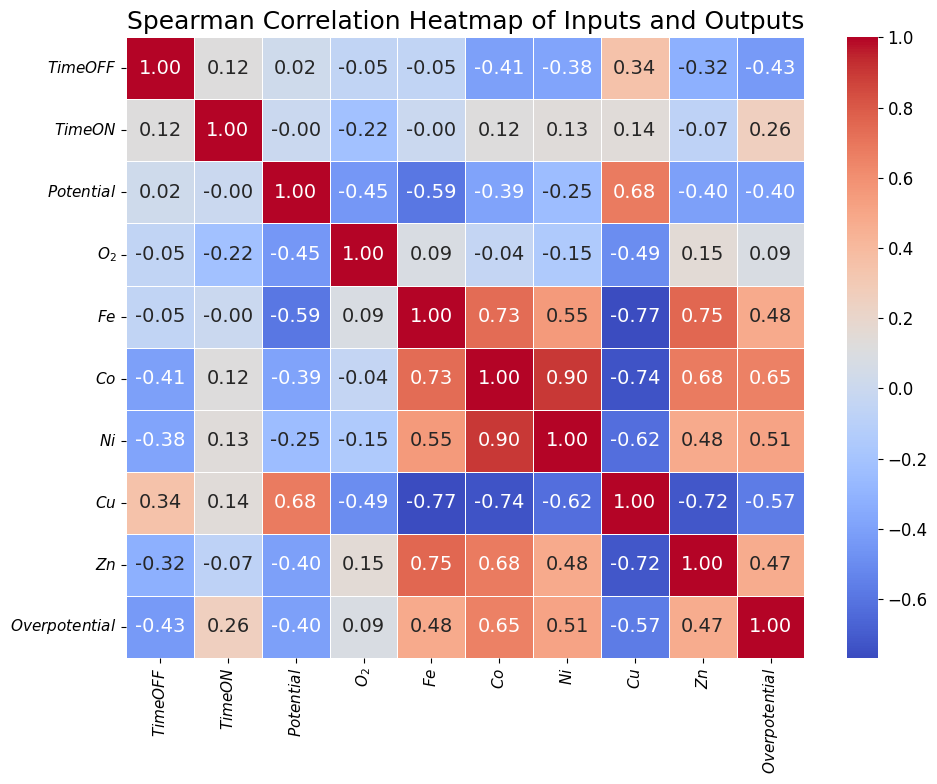

In [6]:
# Calculate the Spearman correlation matrix
correlation_matrix = data.corr(method='spearman')

# Create a heatmap to visualize the correlations
fig = plt.figure(figsize=(10, 8))
hm = sns.heatmap(correlation_matrix, annot=True, annot_kws={'size':14}, cmap='coolwarm', fmt=".2f", linewidths=.5, 
            xticklabels=[r'$'+ label + '$' for label in input_vars + outputs],
            yticklabels=[r'$'+ label + '$' for label in input_vars + outputs])
cbar = hm.collections[0].colorbar
cbar.ax.tick_params(labelsize=12)

plt.title('Spearman Correlation Heatmap of Inputs and Outputs', fontsize=18)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.tight_layout()
plt.show()

fig.savefig('Plots/Spearman Correlation Heatmap.jpg')

# Data Preparation for Active Learning Workflow

In [7]:
train_X = data.iloc[:,:3]
train_y = data.iloc[:,3:-1]
train_z = data.iloc[:,-1]

In [8]:
# Standard Scaling of Data
scaler_x = StandardScaler()
train_X_scaled = scaler_x.fit_transform(train_X)
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(pd.DataFrame(train_y))
scaler_z = StandardScaler()
train_z_scaled = scaler_z.fit_transform(pd.DataFrame(train_z))

In [9]:
# Precompute tensors for your y scaler parameters for later use
scale_y = torch.tensor(scaler_y.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_y  = torch.tensor(scaler_y.mean_).view(1, 1, -1)

scale_z = torch.tensor(scaler_z.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_z  = torch.tensor(scaler_z.mean_).view(1, 1, -1)

In [10]:
train_x_torch = torch.from_numpy(train_X_scaled).float()
train_y_torch = torch.from_numpy(train_y_scaled).float()
train_z_torch = torch.from_numpy(train_z_scaled).float()

# Active learning workflow

## Optimization loop 1

### Build Stacked Gaussian Process (StaGP) regression workflow (StaGPRW)

In [11]:
# Function to compute evaluation metrics for regression models
def compute_metrics(y_true, y_pred):
    """
    Compute and return R², MAE, and RMSE for the given true and predicted values.

    Parameters:
    - y_true: Array of true target values.
    - y_pred: Array of predicted target values.

    Returns:
    - r2: R-squared score.
    - mape: Mean Absolute Error.
    - rmse: Root Mean Squared Error.
    """
    r2 = round(r2_score(y_true, y_pred),3)
    mae = round(mean_absolute_error(y_true, y_pred),2)
    rmse = round(np.sqrt(mean_squared_error(y_true, y_pred)),3)
    
    return r2, mae, rmse

In [12]:
# Function to build the first GP regression model mapping process parameters (X) to composition (y)
def build_multitask_model(train_x_torch, train_y_torch):
    """
    train_x_torch: (N,3) scaled training inputs (Torch Tensor).
    train_y_scaled: (N, 6) scaled training outputs (Torch Tensor).
    """
    # Expand dimensions if needed
    if train_x_torch.ndim == 1:
        train_x_torch = train_x_torch.unsqueeze(-1)
    
    models = []
    for i in range(train_y_torch.shape[1]):
        single_gp = SingleTaskGP(train_x_torch, train_y_torch[:,i:i+1])
        models.append(single_gp)
    multi_gp = ModelListGP(*models)
    mll = SumMarginalLogLikelihood(multi_gp.likelihood, multi_gp)
    return multi_gp, mll

In [13]:
# Build and fit the first model of StaGPRW on scaled X & y data
multigp, sum_mll = build_multitask_model(train_x_torch, train_y_torch)
fit_gpytorch_model(sum_mll)

# Predictions on X data with the mean and variance
multigp.eval()
with torch.no_grad():
    y_posterior = multigp.posterior(train_x_torch)
    y_mean = y_posterior.mean
    y_variance = y_posterior.variance

# Create the prediction intervals
y_lower = y_mean - 2*y_variance.sqrt()
y_upper = y_mean + 2*y_variance.sqrt()

# Scale the predicted data to original data scale
y_pred_mean = scaler_y.inverse_transform(y_mean.numpy())
y_pred_lower = scaler_y.inverse_transform(y_lower.numpy())
y_pred_upper = scaler_y.inverse_transform(y_upper.numpy())

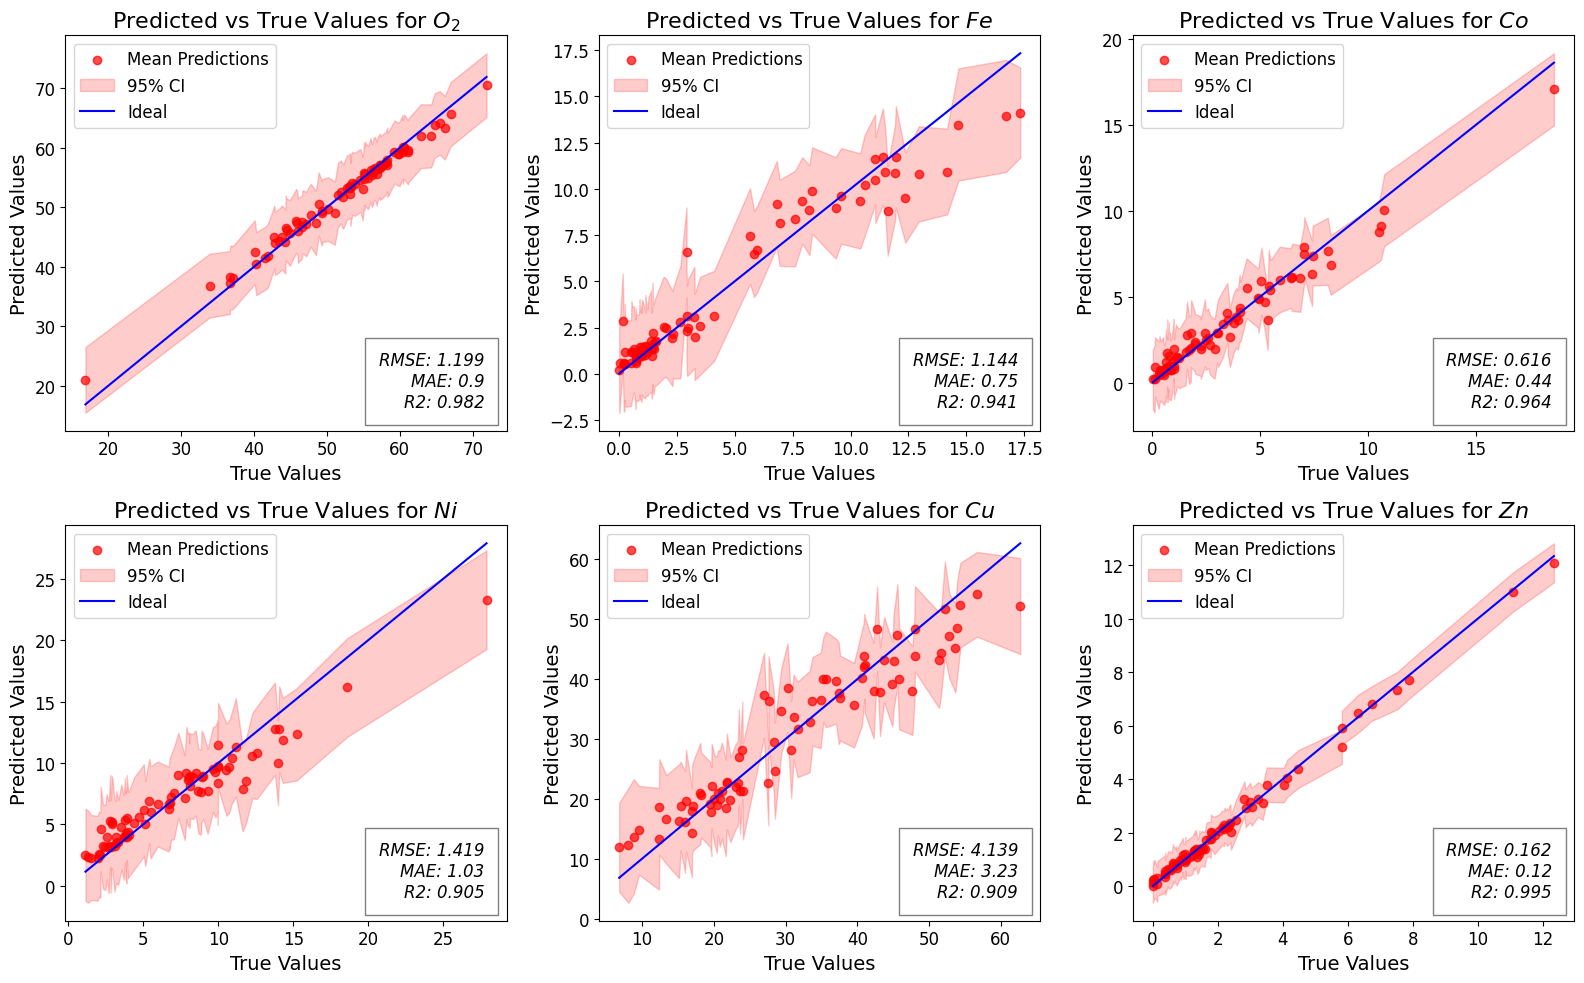

In [14]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
response = ['O_2', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

for i in range(train_y.shape[1]):
    # Performance metrics
    pfm = compute_metrics(train_y.iloc[:, i], y_pred_mean[:, i])
    
    # Sorting indices based on true values
    sorted_indices = np.argsort(train_y.iloc[:, i].values)
    sorted_true_values = train_y.iloc[:, i].values[sorted_indices]
    sorted_y_pred_lower = y_pred_lower[:, i][sorted_indices].ravel()
    sorted_y_pred_mean = y_pred_mean[:, i][sorted_indices].ravel()
    sorted_y_pred_upper = y_pred_upper[:, i][sorted_indices].ravel()

    row, col = (0, i) if i < 3 else (1, i - 3)

    # Plot only non-new data points in red
    ax[row][col].scatter(sorted_true_values, sorted_y_pred_mean, color='red', alpha=0.7, label='Mean Predictions')
    ax[row][col].fill_between(sorted_true_values, sorted_y_pred_lower, sorted_y_pred_upper, color='red', alpha=0.2, label='95% CI')
    ax[row][col].plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')

    ax[row][col].set_xlabel('True Values', fontsize=14)
    ax[row][col].set_ylabel('Predicted Values', fontsize=14)
    ax[row][col].set_title('Predicted vs True Values for '+r'$'+response[i]+'$', fontsize=16)

    ax[row][col].legend(loc='upper left')

    # Metrics box
    box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
    ax[row][col].text(0.95, 0.05, box_text, transform=ax[row][col].transAxes,
                      ha='right', va='bottom', style='italic',
                      bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

In [15]:
fig.savefig('Plots/Model 1 of StaGPRW Performance for Optimization Loop 1.jpg')

In [16]:
# Function to build the second GP regression model mapping composition (y) to HER Overpotential (z)
def build_singletask_model(train_y_torch, train_z_torch):
    """
    train_y_torch: (N, 6) scaled training inputs (Torch tensor).
    train_z_torch: (N, 1) scaled training outputs (Torch tensor).
    """
    # Expand dimensions if needed
    if train_y_torch.ndim == 1:
        train_y_torch = train_y_torch.unsqueeze(-1)
    if train_z_torch.ndim == 1:
        train_z_torch = train_z_torch.unsqueeze(-1)
    
    single_gp = SingleTaskGP(train_y_torch, train_z_torch)
    mll = ExactMarginalLogLikelihood(single_gp.likelihood, single_gp)
    return single_gp, mll

In [17]:
# Build and fit the model on scaled y & z data
singlegp, mll = build_singletask_model(train_y_torch, train_z_torch)
fit_gpytorch_model(mll)

# Predictions on y data and plotting the mean and variance
singlegp.eval()
with torch.no_grad():
    z_posterior = singlegp.posterior(train_y_torch)
    z_mean = z_posterior.mean
    z_variance = z_posterior.variance

# Create the prediction intervals
z_lower = z_mean - 2*z_variance.sqrt()
z_upper = z_mean + 2*z_variance.sqrt()

# Scale the predicted data to original data scale
z_pred_mean = scaler_z.inverse_transform(z_mean.numpy())
z_pred_lower = scaler_z.inverse_transform(z_lower.numpy())
z_pred_upper = scaler_z.inverse_transform(z_upper.numpy())

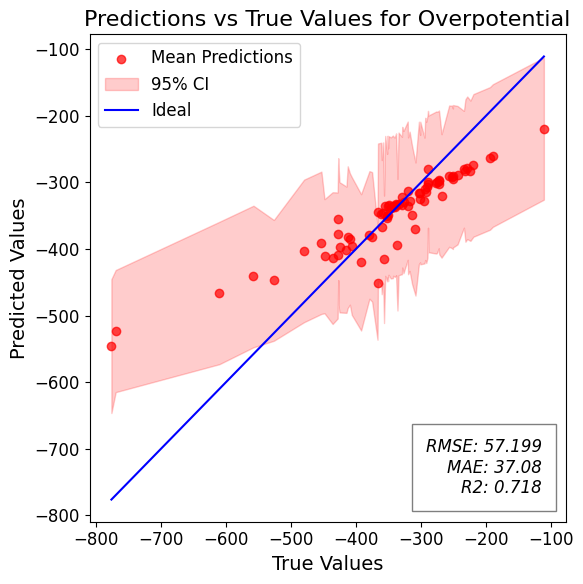

In [18]:
# Performance metrics of z
pfm = compute_metrics(train_z, z_pred_mean)

# Sorting the OverPotential values to ensure proper plotting
sorted_indices = np.argsort(train_z.values)  # Sorting indices for true values to align plots
sorted_true_values = train_z.values[sorted_indices]
sorted_z_pred_lower = z_pred_lower[sorted_indices].ravel()
sorted_z_pred_mean = z_pred_mean[sorted_indices].ravel()
sorted_z_pred_upper = z_pred_upper[sorted_indices].ravel()

fig = plt.figure(figsize=(6, 6))
plt.scatter(sorted_true_values, sorted_z_pred_mean, color='red', alpha=0.7, label='Mean Predictions')
plt.fill_between(sorted_true_values, sorted_z_pred_lower, sorted_z_pred_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')
plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Predictions vs True Values for Overpotential', fontsize=16)
plt.legend(loc='upper left')
box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
plt.text(0.95, 0.05, box_text, transform=plt.gca().transAxes, ha='right', va='bottom', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

In [19]:
fig.savefig('Plots/Model 2 of StagPRW Performance Optimization Loop 1.jpg')

### CHARGE - Constrained Hierarchical Acquisition for Reaction Generation Evaluation

"CHARGE" plays on a key electrochemical concept while highlighting the hierarchical (stacked) nature of your model and its role in evaluating reactions under constraints.

In [20]:
# Custom nested objective function with GenericMCbjective
def charge_objective_fn(Y: torch.Tensor, X: torch.Tensor, model2, alpha: float = 1) -> torch.Tensor:
    r"""
    Custom objective for two-stage GP:
      - Y is shape (sample_shape) x (batch_shape) x (y_shape)
      - Sum(Y) penalty: -alpha * (sum(Y) - 100)
      - Evaluate Z ~ model2.posterior(Y)
      - Return Z + penalty
    """
    # 1) Recover original-space Y
    Y_orig = Y * scale_y + mean_y  # shape [sample_shape, batch_shape, 6]

    # 2) sum over last dimension (the 6 outputs)
    sum_y = Y_orig.sum(dim=-1, keepdim=True)  # -> [sample_shape, batch_shape, 1]
    
    # 3) Penalty in original-space percentage
    penalty = -alpha * abs(sum_y - 100.0)  # [sample_shape, batch_shape, 1]
    
    # 4) Flatten Y so we can pass it to model2 at once
    original_shape = Y.shape[:-1]            # (sample_shape, batch_shape)
    n_points = original_shape.numel()        # total number of points
    Y_flat = Y.view(n_points, 6)            # -> shape [n_points, 6]
    
    # Posterior of z given Y
    post_z = model2.posterior(Y_flat)       # GPyTorch Posterior object
    
    # We can sample from the posterior or take the mean. Let's do 1 sample for simplicity:
    z_samples = post_z.rsample(torch.Size([1]))  # shape [1, n_points, 1]
    z_mean = z_samples.mean(dim=0)               # shape [n_points, 1]
    
    # Reshape back
    z_mean = z_mean.view(*original_shape, 1)     # shape (sample_shape, batch_shape, 1)
    
    # Unscale z_mean
    z_mean = z_mean * scale_z + mean_z  # shape (sample_shape, batch_shape, 1)

    # 5) Combine z and penalty
    # Both z_mean and penalty have shape (..., 1), so we can add them
    objective = z_mean + penalty
    
    # Return shape (sample_shape, batch_shape)
    return objective.squeeze(-1)

# Wrap it in a GenericMCObjective
objective = GenericMCObjective(objective=lambda Y, X: charge_objective_fn(Y, X, singlegp, alpha=1.0))

### Bayesian Optimization

In [21]:
# Define lower and upper bounds arrays of X for optimization
lb = np.array([0, 0, -1.75], dtype=float)
ub = np.array([100, 100, -1.45], dtype=float)

# Apply the standard scaling transformation
scaled_lb = (lb - scaler_x.mean_) / scaler_x.scale_
scaled_ub = (ub - scaler_x.mean_) / scaler_x.scale_

# Create a PyTorch tensor with transformed bounds
scaled_bounds_torch = torch.tensor([scaled_lb, scaled_ub], dtype=torch.float32)

# Define best_f from training data (scaled best observed z value)
best_f = train_z_torch.max()


# Use a sampler for Monte Carlo integration
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

# Set up the acquisition function
acqf = qLogExpectedImprovement(model=multigp, sampler=sampler, objective=objective, best_f=best_f)

# Optimize acquisition function to propose next 5 candidates
candidates, acq_value = optimize_acqf(acq_function=acqf, bounds=scaled_bounds_torch, q=5, num_restarts=10,
                                      raw_samples=500, options={"batch_limit":5, "maxiter": 200})

print("Proposed (scaled) x candidates:", candidates)
print("Proposed (original scale) x candidates:", scaler_x.inverse_transform(candidates.detach().numpy()))

Proposed (scaled) x candidates: tensor([[ 3.8252,  3.4918,  1.8559],
        [-0.4199, -0.2711, -0.4438],
        [ 4.5978,  2.9689,  1.8025],
        [ 0.0937, -0.2574,  0.6576],
        [ 3.4577, -0.9708,  0.2024]], dtype=torch.float32)
Proposed (original scale) x candidates: [[86.32195   81.61501   -1.4502752]
 [22.808851  24.73321   -1.6374156]
 [97.88056   73.709694  -1.4546206]
 [30.49336   24.939547  -1.5477842]
 [80.82327   14.1557    -1.58483  ]]


### Results of Optimization Loop 1

In [22]:
# -----------------------------
# 1. Get Predictions from Model 1 (x -> y)
# -----------------------------
# For a ModelListGP, we loop over each sub-GP and collect their predictions.
y_means = []
y_stds = []
for gp in multigp.models:
    # Call the posterior method with candidate x's.
    posterior = gp.posterior(candidates)
    y_means.append(posterior.mean)             # each: shape (q, 1)
    y_stds.append(posterior.variance.sqrt())     # each: shape (q, 1)

# Concatenate along the output dimension to form (q, 6) where q = 5
y_mean = torch.cat(y_means, dim=-1)  # shape: (5, 6)
y_std = torch.cat(y_stds, dim=-1)      # shape: (5, 6)

# -----------------------------
# 2. Get Predictions from Model 2 (y -> z)
# -----------------------------
# Use the predicted mean y's from Model 1 as input to Model 2.
posterior_z = singlegp.posterior(y_mean)
z_mean = posterior_z.mean            # shape: (5, 1)
z_std = posterior_z.variance.sqrt()    # shape: (5, 1)

# -----------------------------
# 3.  Convert from Scaled to Original Space
# -----------------------------
# To display values in the original scale, inverse-transform them.
# Note: StandardScaler inverse_transform expects numpy arrays.
candidate_orig = scaler_x.inverse_transform(candidates.detach().cpu().numpy())
y_mean_orig = scaler_y.inverse_transform(y_mean.detach().cpu().numpy())
# For standard deviations, if the scaling was linear, you can usually multiply by the scaler's scale_
y_std_orig = y_std.detach().cpu().numpy() * scaler_y.scale_
z_mean_orig = scaler_z.inverse_transform(z_mean.detach().cpu().numpy())
z_std_orig = z_std.detach().cpu().numpy() * scaler_z.scale_

# -----------------------------
# 4. Display the Results in a Table
# -----------------------------
# Create a DataFrame showing each candidate's x, predicted y's, and predicted z.
res_df1 = pd.DataFrame(np.round(candidate_orig,2), columns=train_X.columns)
for i in range(6):
    res_df1[train_y.columns.values[i]+'_mean'] = np.round(y_mean_orig[:, i],2)
    res_df1[train_y.columns.values[i]+'_std'] = np.round(y_std_orig[:, i],2)
res_df1[data.columns[-1]+'_mean'] = np.round(z_mean_orig[:, 0],2)
res_df1[data.columns[-1]+'_std'] = np.round(z_std_orig[:, 0],2)
res_df1

,TimeOFF,TimeON,Potential,O2_mean,O2_std,Fe_mean,Fe_std,Co_mean,Co_std,Ni_mean,Ni_std,Cu_mean,Cu_std,Zn_mean,Zn_std,OverPotential_mean,OverPotential_std
0,86.320000,81.620003,-1.45,51.549999,8.44,5.64,4.00,3.85,3.34,7.88,4.25,26.360001,10.67,2.50,2.42,-322.250000,72.54
1,22.809999,24.730000,-1.64,53.119999,7.73,4.11,3.80,2.21,2.39,6.23,3.12,32.049999,5.81,1.25,1.81,-338.309998,74.49
2,97.879997,73.709999,-1.45,51.549999,8.44,5.65,4.00,3.85,3.34,7.88,4.25,26.270000,10.67,2.50,2.42,-322.179993,72.49
3,30.490000,24.940001,-1.55,48.919998,7.99,3.61,3.90,0.54,2.12,3.39,3.05,49.279999,6.09,0.64,0.83,-356.420013,73.59
4,80.820000,14.160000,-1.58,51.619999,8.44,5.27,3.98,3.85,3.34,7.87,4.25,27.030001,10.62,2.50,2.42,-323.500000,73.25


In [23]:
res_df1.to_excel('Predictions of Optimization Loop 1.xlsx')

## Optimization Loop 2

### Updated Data with 1st optimization loop experimental results

In [64]:
data_1 = pd.read_excel('HER HEO Data with Iteration 1 Results.xlsx')
data_1

,TimeOFF,TimeON,Potential,O2,Fe,Co,Ni,Cu,Zn,OverPotential
0,10.000,10.00,-1.5000,61.1100,0.160,1.800,8.050,28.500,0.3900,-346.51
1,10.000,20.00,-1.5000,44.3400,3.510,7.410,9.810,30.780,4.1400,-301.07
2,10.000,40.00,-1.5000,49.2900,2.040,5.910,10.890,23.970,7.8900,-189.35
3,10.000,50.00,-1.5000,47.1600,3.260,4.930,9.960,28.360,6.3300,-228.81
4,20.000,10.00,-1.5000,71.9000,0.980,0.320,2.700,23.480,0.6300,-610.26
...,...,...,...,...,...,...,...,...,...,...
77,20.409,53.29,-1.5900,35.7000,10.896,11.498,13.976,25.298,2.6380,-275.00
78,43.450,56.84,-1.5800,45.0575,6.260,4.085,6.755,36.530,1.3125,-233.00
79,47.060,61.36,-1.5900,39.5120,6.646,6.074,9.728,36.492,1.5520,-219.00
80,18.690,70.73,-1.5099,30.4980,10.612,11.038,13.526,31.408,2.9180,-253.00


In [65]:
train_X = data_1.iloc[:,:3]
train_y = data_1.iloc[:,3:-1]
train_z = data_1.iloc[:,-1]

In [66]:
# Standard Scaling of Data
scaler_x = StandardScaler()
train_X_scaled = scaler_x.fit_transform(train_X)
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(pd.DataFrame(train_y))
scaler_z = StandardScaler()
train_z_scaled = scaler_z.fit_transform(pd.DataFrame(train_z))

In [ ]:
# Precompute tensors for your y scaler parameters for later use
scale_y = torch.tensor(scaler_y.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_y  = torch.tensor(scaler_y.mean_).view(1, 1, -1)

scale_z = torch.tensor(scaler_z.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_z  = torch.tensor(scaler_z.mean_).view(1, 1, -1)

In [67]:
train_x_torch = torch.from_numpy(train_X_scaled).float()
train_y_torch = torch.from_numpy(train_y_scaled).float()
train_z_torch = torch.from_numpy(train_z_scaled).float()

### Update the model with added data

In [81]:
del multigp
del sum_mll
del singlegp
del mll

In [82]:
# Build and fit the first model of StaGPRW on scaled X & y data
multigp, sum_mll = build_multitask_model(train_x_torch, train_y_torch)
fit_gpytorch_model(sum_mll)

# Predictions on X data with the mean and variance
multigp.eval()
with torch.no_grad():
    y_posterior = multigp.posterior(train_x_torch)
    y_mean = y_posterior.mean
    y_variance = y_posterior.variance

# Create the prediction intervals
y_lower = y_mean - 2*y_variance.sqrt()
y_upper = y_mean + 2*y_variance.sqrt()

# Scale the predicted data to original data scale
y_pred_mean = scaler_y.inverse_transform(y_mean.numpy())
y_pred_lower = scaler_y.inverse_transform(y_lower.numpy())
y_pred_upper = scaler_y.inverse_transform(y_upper.numpy())

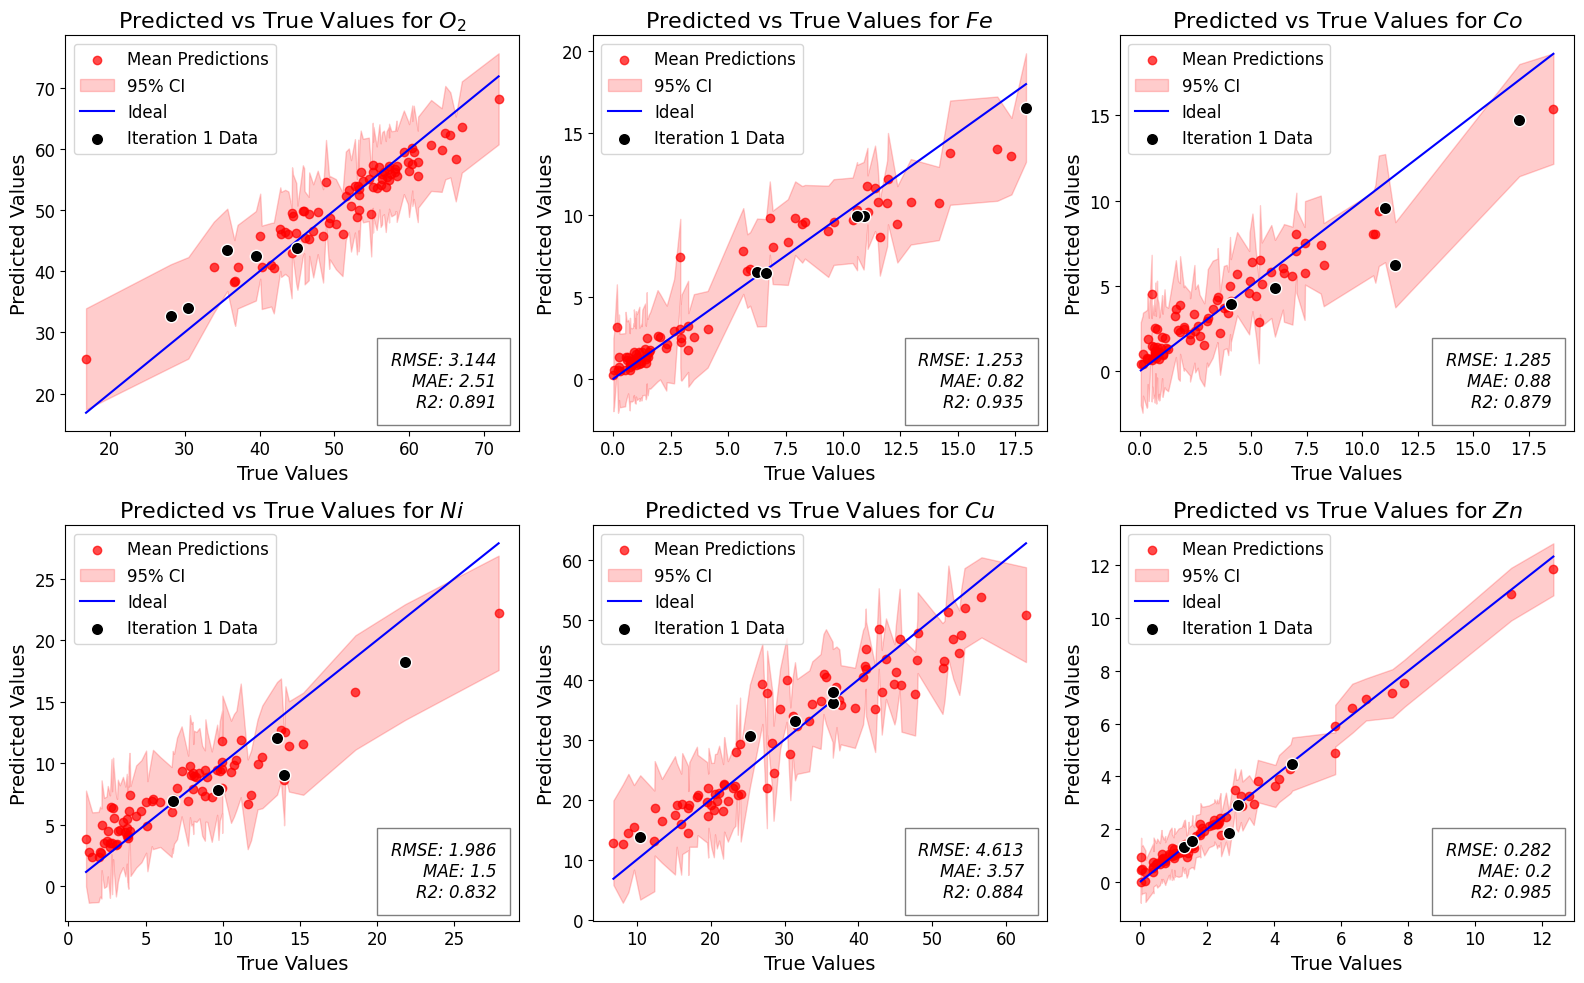

In [83]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
response = ['O_2', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

# Get indices of the newly added data (last 5 rows)
new_data_indices = np.arange(len(train_y)-5, len(train_y))

for i in range(train_y.shape[1]):
    # Performance metrics
    pfm = compute_metrics(train_y.iloc[:, i], y_pred_mean[:, i])
    
    # Sorting indices based on true values
    sorted_indices = np.argsort(train_y.iloc[:, i].values)
    sorted_true_values = train_y.iloc[:, i].values[sorted_indices]
    sorted_y_pred_lower = y_pred_lower[:, i][sorted_indices].ravel()
    sorted_y_pred_mean = y_pred_mean[:, i][sorted_indices].ravel()
    sorted_y_pred_upper = y_pred_upper[:, i][sorted_indices].ravel()

    # Find sorted positions of new data
    new_data_positions = [np.where(sorted_indices == idx)[0][0] for idx in new_data_indices]

    row, col = (0, i) if i < 3 else (1, i - 3)

    # Create a mask to exclude Iteration 1 Data from red points
    mask = np.ones(len(sorted_true_values), dtype=bool)
    mask[new_data_positions] = False  # set False where new data exists

    # Plot only non-new data points in red
    ax[row][col].scatter(np.array(sorted_true_values)[mask], np.array(sorted_y_pred_mean)[mask],
                         color='red', alpha=0.7, label='Mean Predictions')
    ax[row][col].fill_between(sorted_true_values, sorted_y_pred_lower, sorted_y_pred_upper, color='red', alpha=0.2, label='95% CI')
    ax[row][col].plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')

    # Plot the Iteration 1 Data points
    ax[row][col].scatter([sorted_true_values[pos] for pos in new_data_positions], [sorted_y_pred_mean[pos] for pos in new_data_positions],
                         color='black', edgecolors='white', label='Iteration 1 Data', s=80, zorder=5)

    ax[row][col].set_xlabel('True Values', fontsize=14)
    ax[row][col].set_ylabel('Predicted Values', fontsize=14)
    ax[row][col].set_title('Predicted vs True Values for '+r'$'+response[i]+'$', fontsize=16)

    # Only show legend once
    handles, labels = ax[row][col].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[row][col].legend(by_label.values(), by_label.keys(), loc='upper left')

    # Metrics box
    box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
    ax[row][col].text(0.95, 0.05, box_text, transform=ax[row][col].transAxes,
                      ha='right', va='bottom', style='italic',
                      bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

fig.savefig('Plots/Model 1 of StaGPRW Performance for Optimization Loop 2.jpg')

In [84]:
# Build and fit the model on scaled y & z data
singlegp, mll = build_singletask_model(train_y_torch, train_z_torch)
fit_gpytorch_model(mll)

# Predictions on y data and plotting the mean and variance
singlegp.eval()
with torch.no_grad():
    z_posterior = singlegp.posterior(train_y_torch)
    z_mean = z_posterior.mean
    z_variance = z_posterior.variance

# Create the prediction intervals
z_lower = z_mean - 2*z_variance.sqrt()
z_upper = z_mean + 2*z_variance.sqrt()

# Scale the predicted data to original data scale
z_pred_mean = scaler_z.inverse_transform(z_mean.numpy())
z_pred_lower = scaler_z.inverse_transform(z_lower.numpy())
z_pred_upper = scaler_z.inverse_transform(z_upper.numpy())

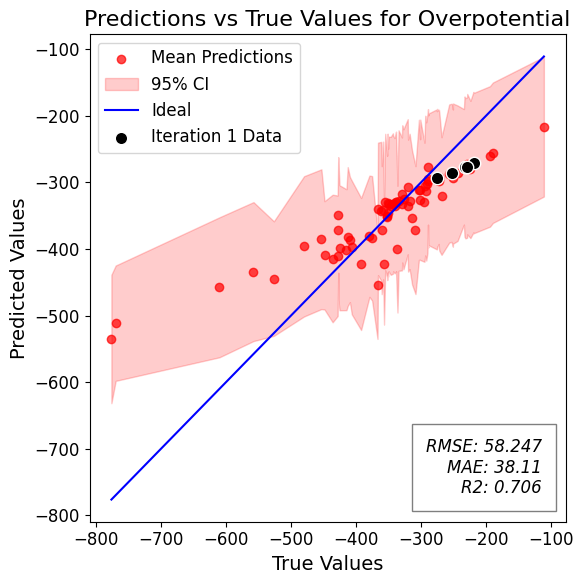

In [85]:
# Performance metrics of z
pfm = compute_metrics(train_z, z_pred_mean)

# Identify new data indices (last 5 rows)
new_data_indices = np.arange(len(train_z) - 5, len(train_z))

# Sorting the OverPotential values to ensure proper plotting
sorted_indices = np.argsort(train_z.values)  # Sorting indices for true values to align plots
sorted_true_values = train_z.values[sorted_indices]
sorted_z_pred_lower = z_pred_lower[sorted_indices].ravel()
sorted_z_pred_mean = z_pred_mean[sorted_indices].ravel()
sorted_z_pred_upper = z_pred_upper[sorted_indices].ravel()

# Get sorted positions of new data
new_data_positions = [np.where(sorted_indices == idx)[0][0] for idx in new_data_indices]

# Mask out new data from main red scatter
mask = np.ones(len(sorted_true_values), dtype=bool)
mask[new_data_positions] = False

# Plot
fig = plt.figure(figsize=(6, 6))
plt.scatter(np.array(sorted_true_values)[mask], np.array(sorted_z_pred_mean)[mask],
            color='red', alpha=0.7, label='Mean Predictions')
plt.fill_between(sorted_true_values, sorted_z_pred_lower, sorted_z_pred_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')

# Plot new data points
plt.scatter([sorted_true_values[pos] for pos in new_data_positions],
            [sorted_z_pred_mean[pos] for pos in new_data_positions],
            color='black', edgecolors='white', s=80, zorder=5, label='Iteration 1 Data')

plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Predictions vs True Values for Overpotential', fontsize=16)

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
plt.text(0.95, 0.05, box_text, transform=plt.gca().transAxes, ha='right', va='bottom', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

fig.savefig('Plots/Model 2 of StagPRW Performance Optimization Loop 2.jpg')

### Bayesian Optimization

In [46]:
# Define lower and upper bounds arrays of X for optimization
lb = np.array([0, 0, -1.75], dtype=float)
ub = np.array([100, 100, -1.45], dtype=float)

# Apply the standard scaling transformation
scaled_lb = (lb - scaler_x.mean_) / scaler_x.scale_
scaled_ub = (ub - scaler_x.mean_) / scaler_x.scale_

# Create a PyTorch tensor with transformed bounds
scaled_bounds_torch = torch.tensor([scaled_lb, scaled_ub], dtype=torch.float32)

# Define best_f from training data (scaled best observed z value)
best_f = train_z_torch.max()


# Use a sampler for Monte Carlo integration
sampler = SobolQMCNormalSampler(sample_shape=torch.Size([128]))

# Set up the acquisition function
acqf = qLogExpectedImprovement(model=multigp, sampler=sampler, objective=objective, best_f=best_f)

# Optimize acquisition function to propose next 5 candidates
candidates, acq_value = optimize_acqf(acq_function=acqf, bounds=scaled_bounds_torch, q=5, num_restarts=10,
                                      raw_samples=500, options={"batch_limit":5, "maxiter": 200})

print("Proposed (scaled) x candidates:", candidates)
print("Proposed (original scale) x candidates:", scaler_x.inverse_transform(candidates.detach().numpy()))

Proposed (scaled) x candidates: tensor([[ 0.0298, -0.2238,  0.6910],
        [ 0.2087, -0.5675,  0.4797],
        [ 0.0591,  0.5042,  0.7299],
        [-1.6645,  3.5544,  1.3707],
        [ 1.6820,  3.2785, -0.6975]], dtype=torch.float32)
Proposed (original scale) x candidates: [[29.562323  27.2259    -1.5453498]
 [32.217857  21.11298   -1.5622845]
 [29.997648  40.175793  -1.542229 ]
 [ 4.414091  94.42897   -1.4908712]
 [54.087044  89.52141   -1.6566371]]


### Results of Optimization Loop 2

In [47]:
# -----------------------------
# 1. Get Predictions from Model 1 (x -> y)
# -----------------------------
# For a ModelListGP, we loop over each sub-GP and collect their predictions.
y_means = []
y_stds = []
for gp in multigp.models:
    # Call the posterior method with candidate x's.
    posterior = gp.posterior(candidates)
    y_means.append(posterior.mean)             # each: shape (q, 1)
    y_stds.append(posterior.variance.sqrt())     # each: shape (q, 1)

# Concatenate along the output dimension to form (q, 6) where q = 5
y_mean = torch.cat(y_means, dim=-1)  # shape: (5, 6)
y_std = torch.cat(y_stds, dim=-1)      # shape: (5, 6)

# -----------------------------
# 2. Get Predictions from Model 2 (y -> z)
# -----------------------------
# Use the predicted mean y's from Model 1 as input to Model 2.
posterior_z = singlegp.posterior(y_mean)
z_mean = posterior_z.mean            # shape: (5, 1)
z_std = posterior_z.variance.sqrt()    # shape: (5, 1)

# -----------------------------
# 3.  Convert from Scaled to Original Space
# -----------------------------
# To display values in the original scale, inverse-transform them.
# Note: StandardScaler inverse_transform expects numpy arrays.
candidate_orig = scaler_x.inverse_transform(candidates.detach().cpu().numpy())
y_mean_orig = scaler_y.inverse_transform(y_mean.detach().cpu().numpy())
# For standard deviations, if the scaling was linear, you can usually multiply by the scaler's scale_
y_std_orig = y_std.detach().cpu().numpy() * scaler_y.scale_
z_mean_orig = scaler_z.inverse_transform(z_mean.detach().cpu().numpy())
z_std_orig = z_std.detach().cpu().numpy() * scaler_z.scale_

# -----------------------------
# 4. Display the Results in a Table
# -----------------------------
# Create a DataFrame showing each candidate's x, predicted y's, and predicted z.
res_df2 = pd.DataFrame(np.round(candidate_orig,2), columns=train_X.columns)
for i in range(6):
    res_df2[train_y.columns.values[i]+'_mean'] = np.round(y_mean_orig[:, i],2)
    res_df2[train_y.columns.values[i]+'_std'] = np.round(y_std_orig[:, i],2)
res_df2[data.columns[-1]+'_mean'] = np.round(z_mean_orig[:, 0],2)
res_df2[data.columns[-1]+'_std'] = np.round(z_std_orig[:, 0],2)
res_df2

,TimeOFF,TimeON,Potential,O2_mean,O2_std,Fe_mean,Fe_std,Co_mean,Co_std,Ni_mean,Ni_std,Cu_mean,Cu_std,Zn_mean,Zn_std,OverPotential_mean,OverPotential_std
0,29.559999,27.230000,-1.55,45.580002,6.30,7.28,4.45,0.46,1.86,3.59,2.83,32.029999,10.19,0.58,0.81,-321.190002,72.65
1,32.220001,21.110001,-1.56,47.860001,6.08,7.25,4.45,0.40,2.04,3.49,2.87,31.799999,9.92,0.89,1.60,-321.410004,72.64
2,30.000000,40.180000,-1.54,41.830002,6.21,7.28,4.45,1.01,1.83,4.97,2.80,32.910000,10.06,0.40,0.73,-320.179993,72.64
3,4.410000,94.430000,-1.49,47.240002,8.87,6.98,4.42,5.62,3.60,9.47,4.39,25.379999,10.24,2.93,2.37,-315.809998,71.20
4,54.090000,89.519997,-1.66,47.950001,8.88,7.28,4.45,5.62,3.56,9.36,4.37,25.379999,10.52,2.35,2.34,-310.559998,71.59


In [49]:
res_df2.to_excel('Predictions of Optimization Loop 2.xlsx')

## Final Model Performance

### Updated Data with 1st and 2nd optimization loop experimental results

In [86]:
data_2 = pd.read_excel('HER HEO Data with Iteration 1 and 2 Results.xlsx')
data_2

,TimeOFF,TimeON,Potential,O2,Fe,Co,Ni,Cu,Zn,OverPotential
0,10.000000,10.000000,-1.50,61.110,0.160,1.800,8.050,28.500,0.390,-346.51
1,10.000000,20.000000,-1.50,44.340,3.510,7.410,9.810,30.780,4.140,-301.07
2,10.000000,40.000000,-1.50,49.290,2.040,5.910,10.890,23.970,7.890,-189.35
3,10.000000,50.000000,-1.50,47.160,3.260,4.930,9.960,28.360,6.330,-228.81
4,20.000000,10.000000,-1.50,71.900,0.980,0.320,2.700,23.480,0.630,-610.26
...,...,...,...,...,...,...,...,...,...,...
82,29.559999,27.230000,-1.55,61.984,19.842,1.542,3.528,10.840,2.264,-350.00
83,32.220001,21.110001,-1.56,56.314,23.002,3.518,5.872,5.806,5.488,-365.00
84,30.000000,40.180000,-1.54,64.426,8.928,1.646,3.894,19.086,2.020,-301.00
85,4.410000,94.430000,-1.49,62.282,8.444,2.150,3.676,20.812,2.630,-359.00


In [87]:
train_X = data_2.iloc[:,:3]
train_y = data_2.iloc[:,3:-1]
train_z = data_2.iloc[:,-1]

In [88]:
# Standard Scaling of Data
scaler_x = StandardScaler()
train_X_scaled = scaler_x.fit_transform(train_X)
scaler_y = StandardScaler()
train_y_scaled = scaler_y.fit_transform(pd.DataFrame(train_y))
scaler_z = StandardScaler()
train_z_scaled = scaler_z.fit_transform(pd.DataFrame(train_z))

In [ ]:
# Precompute tensors for your y scaler parameters for later use
scale_y = torch.tensor(scaler_y.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_y  = torch.tensor(scaler_y.mean_).view(1, 1, -1)

scale_z = torch.tensor(scaler_z.scale_).view(1, 1, -1)  # shape [1,1,6]
mean_z  = torch.tensor(scaler_z.mean_).view(1, 1, -1)

In [89]:
train_x_torch = torch.from_numpy(train_X_scaled).float()
train_y_torch = torch.from_numpy(train_y_scaled).float()
train_z_torch = torch.from_numpy(train_z_scaled).float()

### Update the model with added data

In [90]:
del multigp
del sum_mll
del singlegp
del mll

In [91]:
# Build and fit the first model of StaGPRW on scaled X & y data
multigp, sum_mll = build_multitask_model(train_x_torch, train_y_torch)
fit_gpytorch_model(sum_mll)

# Predictions on X data with the mean and variance
multigp.eval()
with torch.no_grad():
    y_posterior = multigp.posterior(train_x_torch)
    y_mean = y_posterior.mean
    y_variance = y_posterior.variance

# Create the prediction intervals
y_lower = y_mean - 2*y_variance.sqrt()
y_upper = y_mean + 2*y_variance.sqrt()

# Scale the predicted data to original data scale
y_pred_mean = scaler_y.inverse_transform(y_mean.numpy())
y_pred_lower = scaler_y.inverse_transform(y_lower.numpy())
y_pred_upper = scaler_y.inverse_transform(y_upper.numpy())

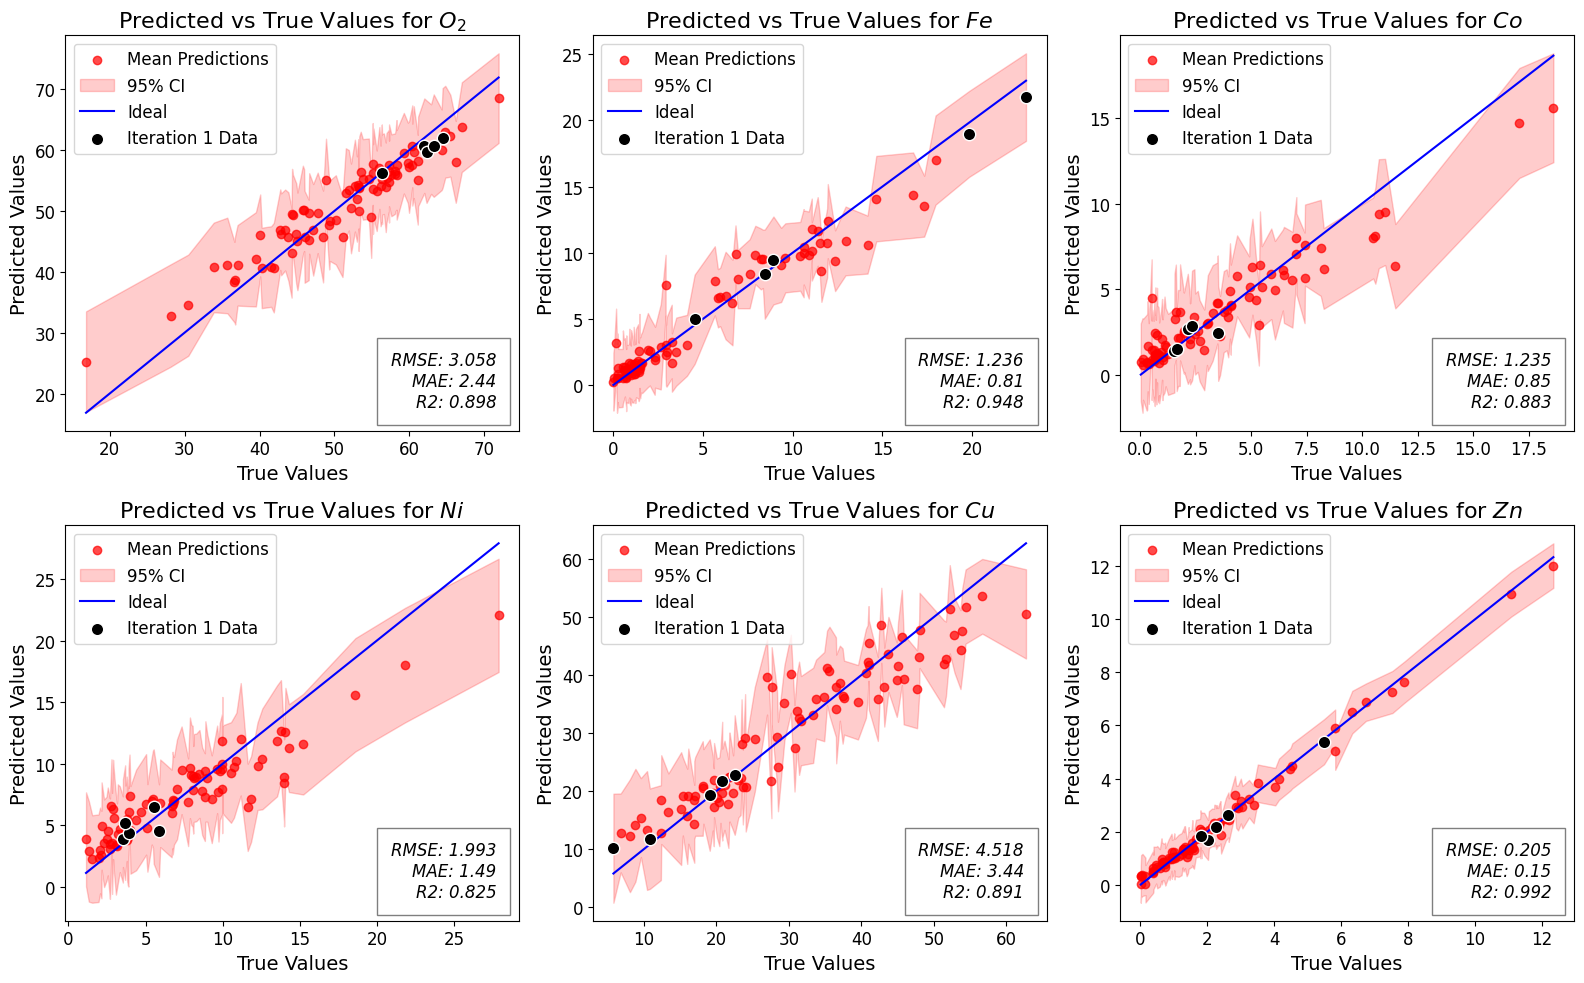

In [92]:
fig, ax = plt.subplots(2, 3, figsize=(16, 10))
response = ['O_2', 'Fe', 'Co', 'Ni', 'Cu', 'Zn']

# Get indices of the newly added data (last 5 rows)
new_data_indices = np.arange(len(train_y)-5, len(train_y))

for i in range(train_y.shape[1]):
    # Performance metrics
    pfm = compute_metrics(train_y.iloc[:, i], y_pred_mean[:, i])
    
    # Sorting indices based on true values
    sorted_indices = np.argsort(train_y.iloc[:, i].values)
    sorted_true_values = train_y.iloc[:, i].values[sorted_indices]
    sorted_y_pred_lower = y_pred_lower[:, i][sorted_indices].ravel()
    sorted_y_pred_mean = y_pred_mean[:, i][sorted_indices].ravel()
    sorted_y_pred_upper = y_pred_upper[:, i][sorted_indices].ravel()

    # Find sorted positions of new data
    new_data_positions = [np.where(sorted_indices == idx)[0][0] for idx in new_data_indices]

    row, col = (0, i) if i < 3 else (1, i - 3)

    # Create a mask to exclude Iteration 1 Data from red points
    mask = np.ones(len(sorted_true_values), dtype=bool)
    mask[new_data_positions] = False  # set False where new data exists

    # Plot only non-new data points in red
    ax[row][col].scatter(np.array(sorted_true_values)[mask], np.array(sorted_y_pred_mean)[mask],
                         color='red', alpha=0.7, label='Mean Predictions')
    ax[row][col].fill_between(sorted_true_values, sorted_y_pred_lower, sorted_y_pred_upper, color='red', alpha=0.2, label='95% CI')
    ax[row][col].plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')

    # Plot the Iteration 1 Data points
    ax[row][col].scatter([sorted_true_values[pos] for pos in new_data_positions], [sorted_y_pred_mean[pos] for pos in new_data_positions],
                         color='black', edgecolors='white', label='Iteration 1 Data', s=80, zorder=5)

    ax[row][col].set_xlabel('True Values', fontsize=14)
    ax[row][col].set_ylabel('Predicted Values', fontsize=14)
    ax[row][col].set_title('Predicted vs True Values for '+r'$'+response[i]+'$', fontsize=16)

    # Only show legend once
    handles, labels = ax[row][col].get_legend_handles_labels()
    by_label = dict(zip(labels, handles))
    ax[row][col].legend(by_label.values(), by_label.keys(), loc='upper left')

    # Metrics box
    box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
    ax[row][col].text(0.95, 0.05, box_text, transform=ax[row][col].transAxes,
                      ha='right', va='bottom', style='italic',
                      bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

fig.savefig('Plots/Model 1 of StaGPRW Final Performance.jpg')

In [93]:
# Build and fit the model on scaled y & z data
singlegp, mll = build_singletask_model(train_y_torch, train_z_torch)
fit_gpytorch_model(mll)

# Predictions on y data and plotting the mean and variance
singlegp.eval()
with torch.no_grad():
    z_posterior = singlegp.posterior(train_y_torch)
    z_mean = z_posterior.mean
    z_variance = z_posterior.variance

# Create the prediction intervals
z_lower = z_mean - 2*z_variance.sqrt()
z_upper = z_mean + 2*z_variance.sqrt()

# Scale the predicted data to original data scale
z_pred_mean = scaler_z.inverse_transform(z_mean.numpy())
z_pred_lower = scaler_z.inverse_transform(z_lower.numpy())
z_pred_upper = scaler_z.inverse_transform(z_upper.numpy())

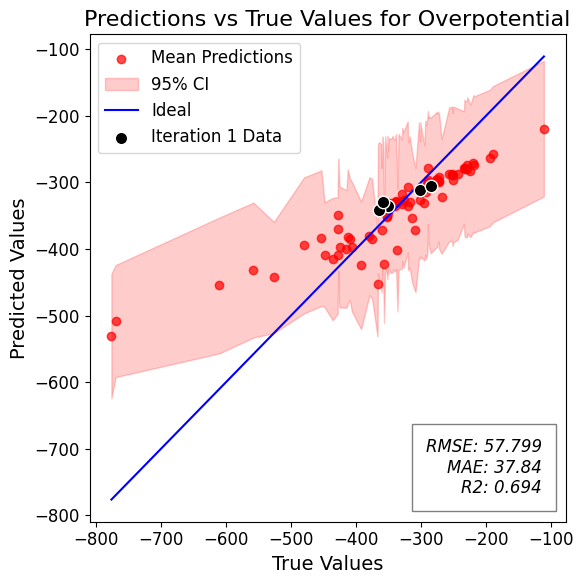

In [94]:
# Performance metrics of z
pfm = compute_metrics(train_z, z_pred_mean)

# Identify new data indices (last 5 rows)
new_data_indices = np.arange(len(train_z) - 5, len(train_z))

# Sorting the OverPotential values to ensure proper plotting
sorted_indices = np.argsort(train_z.values)  # Sorting indices for true values to align plots
sorted_true_values = train_z.values[sorted_indices]
sorted_z_pred_lower = z_pred_lower[sorted_indices].ravel()
sorted_z_pred_mean = z_pred_mean[sorted_indices].ravel()
sorted_z_pred_upper = z_pred_upper[sorted_indices].ravel()

# Get sorted positions of new data
new_data_positions = [np.where(sorted_indices == idx)[0][0] for idx in new_data_indices]

# Mask out new data from main red scatter
mask = np.ones(len(sorted_true_values), dtype=bool)
mask[new_data_positions] = False

# Plot
fig = plt.figure(figsize=(6, 6))
plt.scatter(np.array(sorted_true_values)[mask], np.array(sorted_z_pred_mean)[mask],
            color='red', alpha=0.7, label='Mean Predictions')
plt.fill_between(sorted_true_values, sorted_z_pred_lower, sorted_z_pred_upper, color='red', alpha=0.2, label='95% CI')
plt.plot(sorted_true_values, sorted_true_values, color='blue', label='Ideal')

# Plot new data points
plt.scatter([sorted_true_values[pos] for pos in new_data_positions],
            [sorted_z_pred_mean[pos] for pos in new_data_positions],
            color='black', edgecolors='white', s=80, zorder=5, label='Iteration 1 Data')

plt.xlabel('True Values', fontsize=14)
plt.ylabel('Predicted Values', fontsize=14)
plt.title('Predictions vs True Values for Overpotential', fontsize=16)

# Avoid duplicate legend entries
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper left')

box_text = 'RMSE: ' + str(round(pfm[2], 3)) + '\nMAE: ' + str(round(pfm[1], 2)) + '\nR2: ' + str(round(pfm[0], 3))
plt.text(0.95, 0.05, box_text, transform=plt.gca().transAxes, ha='right', va='bottom', style='italic', bbox={'facecolor':'white', 'alpha':0.5, 'pad':10})

plt.tight_layout()
plt.show()

fig.savefig('Plots/Model 2 of StagPRW Final Performance.jpg')